In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# For data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# For models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

# For evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# For model saving
import pickle

# Load the dataset
df = pd.read_csv('diabetes_data.csv')
print("Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")
df.head()

Dataset loaded successfully!
Dataset shape: (100000, 9)


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [2]:
# Basic information about the dataset
print("Dataset Information:")
print(df.info())
print("\n" + "="*50 + "\n")

print("Statistical Summary:")
print(df.describe())
print("\n" + "="*50 + "\n")

print("Missing Values:")
print(df.isnull().sum())
print("\n" + "="*50 + "\n")

print("Target Variable Distribution:")
print(df['diabetes'].value_counts())
print("\nTarget Variable Percentage:")
print(df['diabetes'].value_counts(normalize=True) * 100)

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB
None


Statistical Summary:
                 age  hypertension  heart_disease            bmi  \
count  100000.000000  100000.00000  100000.000000  100000.000000   
mean       41.885856       0.07485       0.039420      27.320767   
std        22.5

In [3]:
# Check data types and unique values
print("Data Types:")
print(df.dtypes)
print("\n" + "="*50 + "\n")

print("Unique values in each column:")
for col in df.columns:
    print(f"{col}: {df[col].nunique()} unique values")
    if df[col].dtype == 'object':
        print(f"  Categories: {df[col].unique()}")
    print()

Data Types:
gender                  object
age                    float64
hypertension             int64
heart_disease            int64
smoking_history         object
bmi                    float64
HbA1c_level            float64
blood_glucose_level      int64
diabetes                 int64
dtype: object


Unique values in each column:
gender: 3 unique values
  Categories: ['Female' 'Male' 'Other']

age: 102 unique values

hypertension: 2 unique values

heart_disease: 2 unique values

smoking_history: 6 unique values
  Categories: ['never' 'No Info' 'current' 'former' 'ever' 'not current']

bmi: 4247 unique values

HbA1c_level: 18 unique values

blood_glucose_level: 18 unique values

diabetes: 2 unique values



## Data Cleaning

In [4]:
# Check for duplicates
print(f"Number of duplicate rows: {df.duplicated().sum()}")

# Remove duplicates if any
df_cleaned = df.drop_duplicates()
print(f"Shape after removing duplicates: {df_cleaned.shape}")

# Handle missing values
print("\nMissing values before handling:")
print(df_cleaned.isnull().sum())

# Since there are no missing values in the dataset, we'll move forward
# If there were, we could use strategies like mean/median imputation or dropping rows

print("\nData cleaning completed!")
print(f"Final dataset shape: {df_cleaned.shape}")

Number of duplicate rows: 3854
Shape after removing duplicates: (96146, 9)

Missing values before handling:
gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

Data cleaning completed!
Final dataset shape: (96146, 9)


## Outlier Detection and Removal

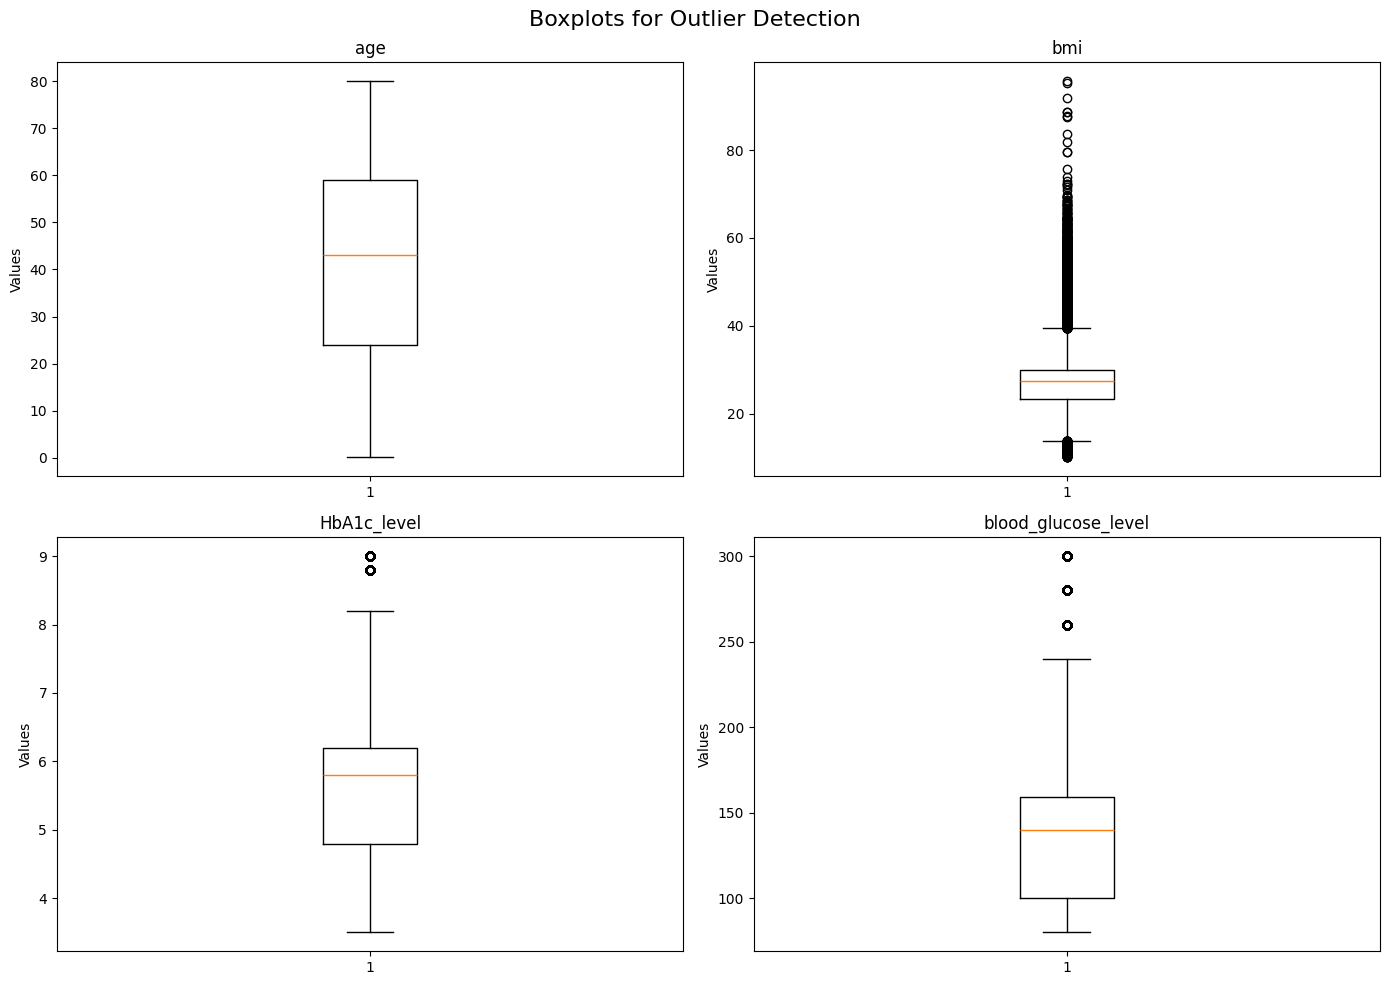

Initial shape: (96146, 9)


In [5]:
# Select numerical columns for outlier detection
numerical_cols = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']

# Visualize outliers using boxplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Boxplots for Outlier Detection', fontsize=16)

for idx, col in enumerate(numerical_cols):
    row = idx // 2
    col_idx = idx % 2
    axes[row, col_idx].boxplot(df_cleaned[col].dropna())
    axes[row, col_idx].set_title(f'{col}')
    axes[row, col_idx].set_ylabel('Values')

plt.tight_layout()
plt.show()

print("Initial shape:", df_cleaned.shape)

In [6]:
# Remove outliers using IQR method
def remove_outliers_iqr(df, columns):
    df_no_outliers = df.copy()
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Count outliers
        outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
        print(f"{col}: {outliers} outliers detected (Lower: {lower_bound:.2f}, Upper: {upper_bound:.2f})")
        
        # Remove outliers
        df_no_outliers = df_no_outliers[(df_no_outliers[col] >= lower_bound) & 
                                         (df_no_outliers[col] <= upper_bound)]
    
    return df_no_outliers

print("Outlier Analysis:")
df_cleaned = remove_outliers_iqr(df_cleaned, numerical_cols)

print(f"\nShape after removing outliers: {df_cleaned.shape}")
print(f"Rows removed: {df.shape[0] - df_cleaned.shape[0]}")

Outlier Analysis:
age: 0 outliers detected (Lower: -28.50, Upper: 111.50)
bmi: 5354 outliers detected (Lower: 13.71, Upper: 39.55)
HbA1c_level: 1312 outliers detected (Lower: 2.70, Upper: 8.30)
blood_glucose_level: 2031 outliers detected (Lower: 11.50, Upper: 247.50)

Shape after removing outliers: (88195, 9)
Rows removed: 11805


## Feature Engineering and Encoding

In [7]:
# Encode categorical variables
print("Categorical columns to encode:")
print(df_cleaned.select_dtypes(include=['object']).columns.tolist())

# Create a copy for encoding
df_encoded = df_cleaned.copy()

# Encode 'gender' column
label_encoder_gender = LabelEncoder()
df_encoded['gender'] = label_encoder_gender.fit_transform(df_encoded['gender'])
print(f"\nGender encoding: {dict(zip(label_encoder_gender.classes_, label_encoder_gender.transform(label_encoder_gender.classes_)))}")

# Encode 'smoking_history' column
label_encoder_smoking = LabelEncoder()
df_encoded['smoking_history'] = label_encoder_smoking.fit_transform(df_encoded['smoking_history'])
print(f"Smoking history encoding: {dict(zip(label_encoder_smoking.classes_, label_encoder_smoking.transform(label_encoder_smoking.classes_)))}")

print("\nEncoded dataset:")
print(df_encoded.head())
print(f"\nData types after encoding:")
print(df_encoded.dtypes)

Categorical columns to encode:
['gender', 'smoking_history']

Gender encoding: {'Female': 0, 'Male': 1, 'Other': 2}
Smoking history encoding: {'No Info': 0, 'current': 1, 'ever': 2, 'former': 3, 'never': 4, 'not current': 5}

Encoded dataset:
   gender   age  hypertension  heart_disease  smoking_history    bmi  \
0       0  80.0             0              1                4  25.19   
1       0  54.0             0              0                0  27.32   
2       1  28.0             0              0                4  27.32   
3       0  36.0             0              0                1  23.45   
4       1  76.0             1              1                1  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0  

Data types after encoding:
gender  

## Feature Selection and Data Splitting

In [8]:
# Separate features and target
X = df_encoded.drop('diabetes', axis=1)
y = df_encoded['diabetes']

print("Features (X):")
print(X.head())
print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")
print(f"\nTarget distribution in training set:")
print(y_train.value_counts(normalize=True))

Features (X):
   gender   age  hypertension  heart_disease  smoking_history    bmi  \
0       0  80.0             0              1                4  25.19   
1       0  54.0             0              0                0  27.32   
2       1  28.0             0              0                4  27.32   
3       0  36.0             0              0                1  23.45   
4       1  76.0             1              1                1  20.14   

   HbA1c_level  blood_glucose_level  
0          6.6                  140  
1          6.6                   80  
2          5.7                  158  
3          5.0                  155  
4          4.8                  155  

Features shape: (88195, 8)
Target shape: (88195,)

Training set size: 70556
Testing set size: 17639

Target distribution in training set:
diabetes
0    0.947644
1    0.052356
Name: proportion, dtype: float64


## Feature Scaling

In [9]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling completed!")
print(f"Scaled training data shape: {X_train_scaled.shape}")
print(f"Scaled testing data shape: {X_test_scaled.shape}")

Feature scaling completed!
Scaled training data shape: (70556, 8)
Scaled testing data shape: (17639, 8)


## Train Multiple Classification Models

In [10]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100),
    'XGBoost': XGBClassifier(random_state=42, n_estimators=100, eval_metric='logloss'),
    'SVM': SVC(random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB()
}

# Dictionary to store results
results = []

# Train and evaluate each model
print("Training models...\n")
for name, model in models.items():
    print(f"Training {name}...")
    
    # Train the model
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    # Store results
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })
    
    print(f"  Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}\n")

print("All models trained successfully!")

Training models...

Training Logistic Regression...
  Accuracy: 0.9624, Precision: 0.7941, Recall: 0.3799, F1-Score: 0.5139

Training Decision Tree...
  Accuracy: 0.9536, Precision: 0.5546, Recall: 0.5768, F1-Score: 0.5655

Training Random Forest...
  Accuracy: 0.9715, Precision: 0.8994, Recall: 0.5130, F1-Score: 0.6533

Training Gradient Boosting...
  Accuracy: 0.9739, Precision: 0.9773, Recall: 0.5130, F1-Score: 0.6728

Training XGBoost...
  Accuracy: 0.9724, Precision: 0.9041, Recall: 0.5303, F1-Score: 0.6685

Training SVM...
  Accuracy: 0.9655, Precision: 0.9646, Recall: 0.3539, F1-Score: 0.5178

Training KNN...
  Accuracy: 0.9630, Precision: 0.7857, Recall: 0.4048, F1-Score: 0.5343

Training Naive Bayes...
  Accuracy: 0.9073, Precision: 0.2577, Recall: 0.4091, F1-Score: 0.3162

All models trained successfully!


## Model Comparison Table

In [ ]:
# Create results dataframe
results_df = pd.DataFrame(results)

# Sort by F1-Score (or any other metric)
results_df = results_df.sort_values('F1-Score', ascending=False).reset_index(drop=True)

# Display the table
print("=" * 80)
print("MODEL COMPARISON TABLE")
print("=" * 80)
print(results_df.to_string(index=False))
print("=" * 80)

# Also display as a styled dataframe
results_df.style.highlight_max(subset=['Accuracy', 'Precision', 'Recall', 'F1-Scorte'], 
                                color='lightgreen', axis=0)

MODEL COMPARISON TABLE
              Model  Accuracy  Precision   Recall  F1-Score
  Gradient Boosting  0.973865   0.977320 0.512987  0.672818
            XGBoost  0.972447   0.904059 0.530303  0.668486
      Random Forest  0.971484   0.899431 0.512987  0.653343
      Decision Tree  0.953569   0.554631 0.576840  0.565517
                KNN  0.963036   0.785714 0.404762  0.534286
                SVM  0.965474   0.964602 0.353896  0.517815
Logistic Regression  0.962356   0.794118 0.379870  0.513909
        Naive Bayes  0.907308   0.257669 0.409091  0.316186


,Model,Accuracy,Precision,Recall,F1-Score
0,Gradient Boosting,0.973865,0.977320,0.512987,0.672818
1,XGBoost,0.972447,0.904059,0.530303,0.668486
2,Random Forest,0.971484,0.899431,0.512987,0.653343
3,Decision Tree,0.953569,0.554631,0.576840,0.565517
4,KNN,0.963036,0.785714,0.404762,0.534286
5,SVM,0.965474,0.964602,0.353896,0.517815
6,Logistic Regression,0.962356,0.794118,0.379870,0.513909
7,Naive Bayes,0.907308,0.257669,0.409091,0.316186


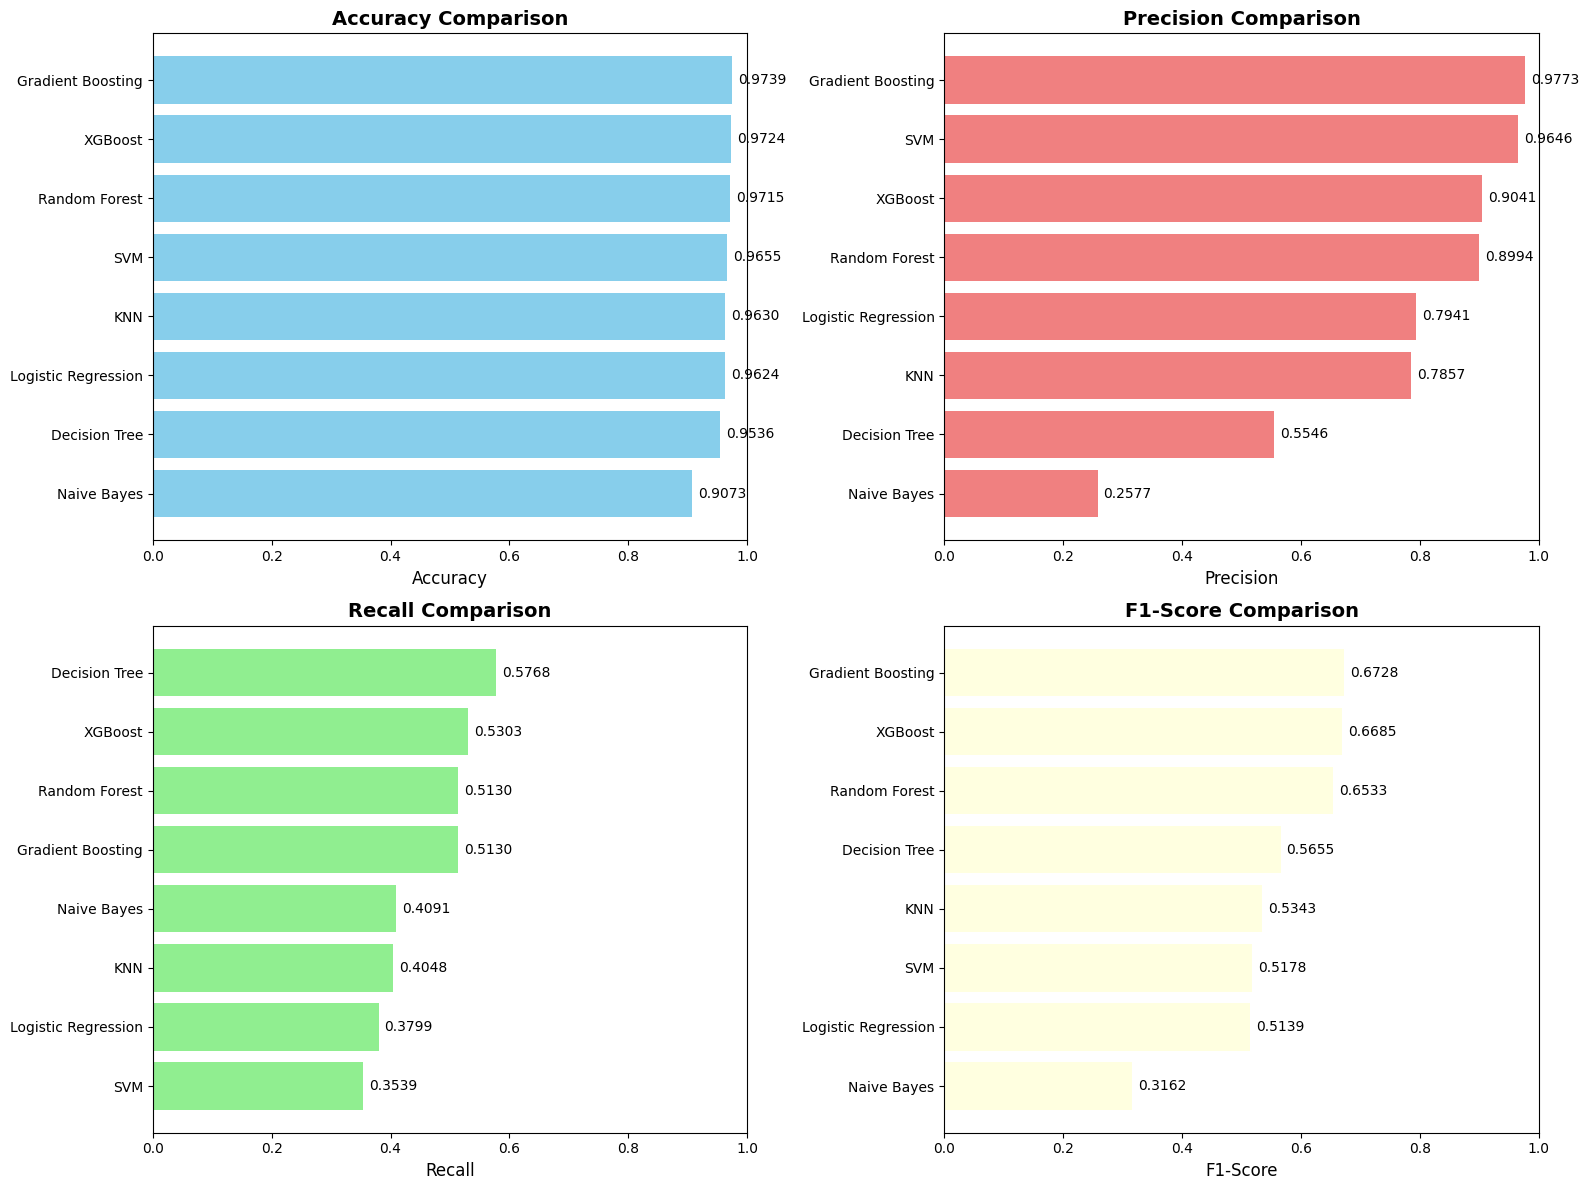

Model comparison chart saved as 'model_comparison.png'


In [12]:
# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['skyblue', 'lightcoral', 'lightgreen', 'lightyellow']

for idx, metric in enumerate(metrics):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    
    sorted_results = results_df.sort_values(metric, ascending=True)
    ax.barh(sorted_results['Model'], sorted_results[metric], color=colors[idx])
    ax.set_xlabel(metric, fontsize=12)
    ax.set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    ax.set_xlim(0, 1)
    
    # Add value labels
    for i, v in enumerate(sorted_results[metric]):
        ax.text(v + 0.01, i, f'{v:.4f}', va='center')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Model comparison chart saved as 'model_comparison.png'")

## Select Best Model and Retrain

BEST MODEL SELECTED
Model: Gradient Boosting
Accuracy: 0.9739
Precision: 0.9773
Recall: 0.5130
F1-Score: 0.6728


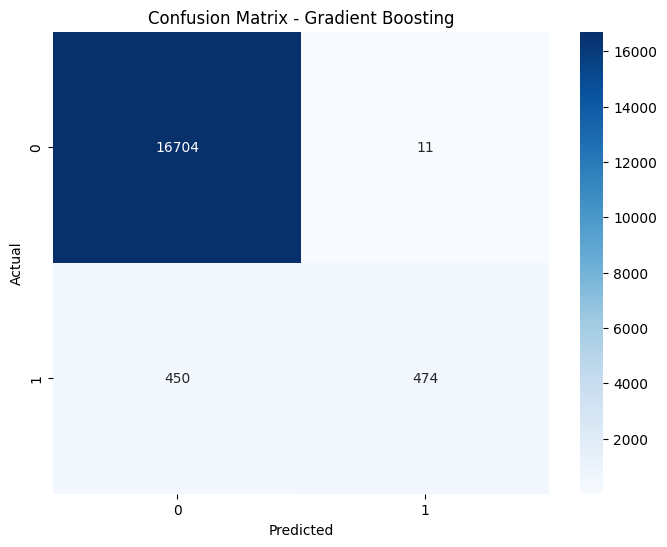


Classification Report:
              precision    recall  f1-score   support

Non-Diabetic       0.97      1.00      0.99     16715
    Diabetic       0.98      0.51      0.67       924

    accuracy                           0.97     17639
   macro avg       0.98      0.76      0.83     17639
weighted avg       0.97      0.97      0.97     17639



In [13]:
# Select the best model based on F1-Score
best_model_name = results_df.iloc[0]['Model']
best_model_metrics = results_df.iloc[0]

print("=" * 80)
print("BEST MODEL SELECTED")
print("=" * 80)
print(f"Model: {best_model_name}")
print(f"Accuracy: {best_model_metrics['Accuracy']:.4f}")
print(f"Precision: {best_model_metrics['Precision']:.4f}")
print(f"Recall: {best_model_metrics['Recall']:.4f}")
print(f"F1-Score: {best_model_metrics['F1-Score']:.4f}")
print("=" * 80)

# Get the best model instance
best_model = models[best_model_name]

# Display confusion matrix for best model
y_pred_best = best_model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('confusion_matrix_best_model.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred_best, target_names=['Non-Diabetic', 'Diabetic']))

## Save Model and Preprocessing Objects as Pickle

In [14]:
# Save the best model
with open('diabetes_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)
print("✓ Model saved as 'diabetes_model.pkl'")

# Save the scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("✓ Scaler saved as 'scaler.pkl'")

# Save the label encoders
with open('label_encoder_gender.pkl', 'wb') as f:
    pickle.dump(label_encoder_gender, f)
print("✓ Gender encoder saved as 'label_encoder_gender.pkl'")

with open('label_encoder_smoking.pkl', 'wb') as f:
    pickle.dump(label_encoder_smoking, f)
print("✓ Smoking encoder saved as 'label_encoder_smoking.pkl'")

# Save feature names
feature_names = X.columns.tolist()
with open('feature_names.pkl', 'wb') as f:
    pickle.dump(feature_names, f)
print("✓ Feature names saved as 'feature_names.pkl'")

print("\n" + "=" * 80)
print("ALL PICKLE FILES CREATED SUCCESSFULLY!")
print("=" * 80)
print("Files created:")
print("  1. diabetes_model.pkl")
print("  2. scaler.pkl")
print("  3. label_encoder_gender.pkl")
print("  4. label_encoder_smoking.pkl")
print("  5. feature_names.pkl")
print("=" * 80)

✓ Model saved as 'diabetes_model.pkl'
✓ Scaler saved as 'scaler.pkl'
✓ Gender encoder saved as 'label_encoder_gender.pkl'
✓ Smoking encoder saved as 'label_encoder_smoking.pkl'
✓ Feature names saved as 'feature_names.pkl'

ALL PICKLE FILES CREATED SUCCESSFULLY!
Files created:
  1. diabetes_model.pkl
  2. scaler.pkl
  3. label_encoder_gender.pkl
  4. label_encoder_smoking.pkl
  5. feature_names.pkl


## Test the Model with Sample Predictions

In [16]:
# Test Person 1
person1_data = {
    'gender': 'Female',
    'age': 50,
    'hypertension': 1,
    'heart_disease': 1,
    'smoking_history': 'No Info',
    'bmi': 32.35,
    'HbA1c_level': 6.23,
    'blood_glucose_level': 80
}

# Test Person 2
person2_data = {
    'gender': 'Male',  # Fixed: capitalize to match encoder
    'age': 30,
    'hypertension': 0,
    'heart_disease': 0,
    'smoking_history': 'current',
    'bmi': 26.15,
    'HbA1c_level': 4.23,
    'blood_glucose_level': 90
}

def predict_diabetes(person_data):
    # Create dataframe
    df_test = pd.DataFrame([person_data])
    
    # Normalize gender case
    df_test['gender'] = df_test['gender'].str.capitalize()
    
    # Encode gender
    df_test['gender'] = label_encoder_gender.transform([df_test['gender'].values[0]])
    
    # Encode smoking history
    df_test['smoking_history'] = label_encoder_smoking.transform([df_test['smoking_history'].values[0]])
    
    # Ensure correct column order
    df_test = df_test[feature_names]
    
    # Scale features
    df_test_scaled = scaler.transform(df_test)
    
    # Make prediction
    prediction = best_model.predict(df_test_scaled)
    probability = best_model.predict_proba(df_test_scaled) if hasattr(best_model, 'predict_proba') else None
    
    return prediction[0], probability

# Test Person 1
print("=" * 80)
print("PERSON 1 PREDICTION")
print("=" * 80)
print(f"Input Data: {person1_data}")
pred1, prob1 = predict_diabetes(person1_data)
print(f"\nPrediction: {'Diabetic' if pred1 == 1 else 'Non-Diabetic'}")
if prob1 is not None:
    print(f"Probability: Non-Diabetic: {prob1[0][0]:.4f}, Diabetic: {prob1[0][1]:.4f}")
print("=" * 80)

# Test Person 2
print("\n" + "=" * 80)
print("PERSON 2 PREDICTION")
print("=" * 80)
print(f"Input Data: {person2_data}")
pred2, prob2 = predict_diabetes(person2_data)
print(f"\nPrediction: {'Diabetic' if pred2 == 1 else 'Non-Diabetic'}")
if prob2 is not None:
    print(f"Probability: Non-Diabetic: {prob2[0][0]:.4f}, Diabetic: {prob2[0][1]:.4f}")
print("=" * 80)

PERSON 1 PREDICTION
Input Data: {'gender': 'Female', 'age': 50, 'hypertension': 1, 'heart_disease': 1, 'smoking_history': 'No Info', 'bmi': 32.35, 'HbA1c_level': 6.23, 'blood_glucose_level': 80}

Prediction: Non-Diabetic
Probability: Non-Diabetic: 0.9973, Diabetic: 0.0027

PERSON 2 PREDICTION
Input Data: {'gender': 'Male', 'age': 30, 'hypertension': 0, 'heart_disease': 0, 'smoking_history': 'current', 'bmi': 26.15, 'HbA1c_level': 4.23, 'blood_glucose_level': 90}

Prediction: Non-Diabetic
Probability: Non-Diabetic: 0.9996, Diabetic: 0.0004
